# Autoencoders


#### I did my best to minimize the training time. I had saved a model that was trained already. However, the server does not play along. Therefore it is best to just do something else for an hour when training. You don't have to train 100 epochs, you can end the training early via Kernel > Interrupt Kernel.
---
**Learning Objectives**
- You understand the concept of an autoencoder
- You understand the meaning of `<sos>`/`<eos>` tokens 
- You understand how an RNN can generate Smiles
- You can also define a network as a PyTorch class
---

In today's notebook we will deal with the so called **autoencoders**.
Autoencoders are mostly trained through selfsupervised training.
As a reminder, selfsupervised training refers to training neural networks where input and output are identical. So the goal is to recover the input. 

But what is the added value of a network that only recovers the input?
In fact, we are not necessarily interested in the output of an autoencoder. Rather, we are interested in what happens in the middle of the network. 
This is because the real goal of autoencoders is to compress the data, that is, to represent it as effectively as possible.

The example image shows an autoencoder for images:



<img src="https://d3i71xaburhd42.cloudfront.net/b1786e74e233ac21f503f59d03f6af19a3699024/2-Figure1-1.png" >

*Yifei Zhang - A Better Autoencoder for Image: Convolutional Autoencoder* **2018**


An autoencoder consists of two networks, an **encoder** and a **decoder**. The output of the encoder is used as input to the decoder. The encoder should learn to represent the data as effectively as possible in a low-dimensional space (latent space). This representation is usually simply a vector, also known as a **latent vector**. The decoder is trained to recover the original input using this latent vector. 

We can decide for ourselves how large the latent vector should be. Usually, a particularly small size is chosen to ensure greater compression.
After successful training, the *latent vector* should contain enough information for the decoder to reconstruct the complete image, despite its small size. This means that this vector is sufficiently informative to describe the complete image. Actual applications go beyond simple reconstruction.

For example, autoencoders are used to improve the quality of images. For this purpose, low-resolution images are used as input, and the output is the same image in its regular (higher) resolution. In this way, networks are trained that can later sharpen low-resolution images. 


<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60bcd0b7b750bae1a953d61d_autoencoder.png" width ="400px">

*Hmrishav Bandyopadhyay - An Introduction to Autoencoders: Everything You Need to Know* **2021**


Autoencoders exist not only for images, but also for text. RNNs are used for this purpose. 
In the last notebook we already discussed that the last hidden state of an RNN is a summary of the whole input sequence. In the example the hidden state $O_5$



<img src="https://miro.medium.com/max/724/1*1U8H9EZiDqfylJU7Im23Ag.gif">

*Michael Phi - An illustrated Guide to Recurrent Neural Networks*


The output $O_5$ can already be understood as a projection of the entire sentence into the latent space. The hidden state $O5$ is thus the latent vector describing our sequence. Accordingly, the network that generated this vector is our encoder. So, all that is missing for our autoencoder is the decoder that can recover the original sequence from the latent vector. We will discuss how this works exactly using an example with smiles.

In [23]:
import pandas as pd
import numpy as np
np.random.seed(1234)
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sys
from os.path import exists, isdir
import os 
if 'google.colab' in sys.modules:
    !pip install rdkit==2022.3.4
    if exists("utils.py") == False:
        !wget https://raw.githubusercontent.com/kochgroup/intro_pharma_ai/main/utils/utils.py
    if exists("load_fragments.ipynb") == False:
        !wget https://raw.githubusercontent.com/kochgroup/intro_pharma_ai/main/utils/load_fragments.ipynb
    %run utils.py
    %run load_fragments.ipynb
else:
    %run ../utils/utils.py
    %run ../utils/load_fragments.ipynb
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')  

This week we are using a dataset that consits of a subset of the GDB 11 developed by the Reymond Group. Only small fragments are used. It is particularly important for this example thha the molecules are not too large as it is difficult to generate a valid smiles from a latent vector. The longer the Smiles get, the more complex the task becomes for the network.

This week the molecules are also available in a different file format. In the `.sdf` format the molecules are stored with more detail. For example, information about the conformation can be stored here. 

---
Fink, T., & Reymond, J. L.. Virtual exploration of the chemical universe up to 11 atoms of C, N, O, F: assembly of 26.4 million structures (110.9 million stereoisomers) and analysis for new ring systems, stereochemistry, physicochemical properties, compound classes, and drug discovery. J. Chem. Inf. Model. **2007** 47(2), 342-353.

---


```

  Mrv0541 07182119162D          

 12 12  0  0  0  0            999 V2000
    0.7145    2.0625    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145    1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.1434   -0.4125    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -1.6500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.6500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145   -0.4125    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  2  3  4  0  0  0  0
  3  4  4  0  0  0  0
  4  5  1  0  0  0  0
  4  6  4  0  0  0  0
  6  7  1  0  0  0  0
  7  8  2  0  0  0  0
  7  9  1  0  0  0  0
  6 10  4  0  0  0  0
 10 11  1  0  0  0  0
 10 12  4  0  0  0  0
  2 12  4  0  0  0  0
M  END
>  <Catalog ID>
Z1255462241

>  <PlateID>
1225133-R3-01

>  <Well>
A02

>  <MW (desalted)>
172.129

>  <CLogP>
2.082

>  <HBD>
1

>  <TPSA>
37.300

>  <RotBonds>
1

```
You can also see additional information like TPSA or LogP can be saved in the same file.

To read such a `.sdf` file into Python we need a so called `MolSupplier` from `rdkit`. A supplier establishes the connection between our files and Python. With a `for-loop` the smiles can be generated from the SDF file.

In [24]:
suppl = Chem.SDMolSupplier("../data/high_fidelity/fragments.sdf")

In [25]:
smiles = []
for mol in suppl:
    smiles.append(Chem.MolToSmiles(mol)) 
smiles[:10]

['CCCCCCC(=O)OCCC',
 'CC(C)=CCCC(C)C1CCC(C)CC1',
 'CCCCC(C)CC',
 'O=C([O-])C=Cc1ccc(O)cc1',
 'O=C1CCCCCCCCCCCCCCO1',
 'Oc1ccccc1-c1ccccc1',
 'CSCCCO',
 'CC1=CC(=O)C2CC1C2(C)C',
 'CCCCCCOC=O',
 'C=CCCCCCCCCCCCCC']

As you can see, this is another way to read in molecules into python.

We can display the structures once to get a better feel for the nature of the fragments.

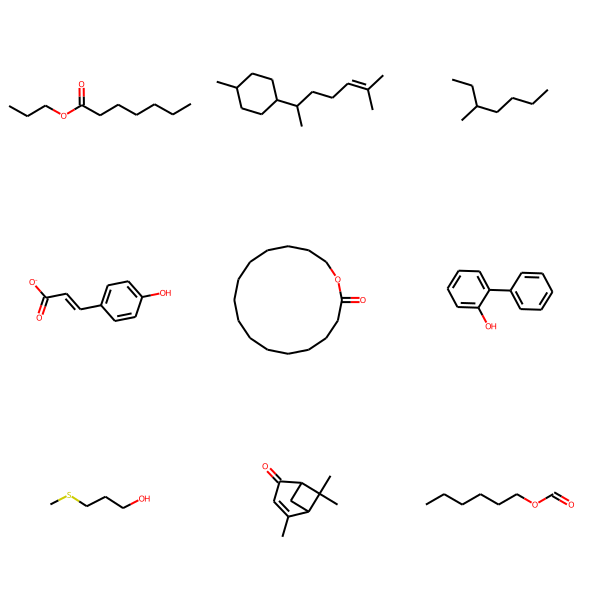

In [26]:
MolsToGridImage([Chem.MolFromSmiles(x)for x in smiles[:9]])

In [27]:
len(smiles)

1675

In total, we have 1675 molecules in the data set.

When you look closely at the Smiles, do you notice anything?

In [28]:
smiles

['CCCCCCC(=O)OCCC',
 'CC(C)=CCCC(C)C1CCC(C)CC1',
 'CCCCC(C)CC',
 'O=C([O-])C=Cc1ccc(O)cc1',
 'O=C1CCCCCCCCCCCCCCO1',
 'Oc1ccccc1-c1ccccc1',
 'CSCCCO',
 'CC1=CC(=O)C2CC1C2(C)C',
 'CCCCCCOC=O',
 'C=CCCCCCCCCCCCCC',
 'CCC(=O)[O-]',
 'C=CC=CC=CCCCCC',
 'C=CCCCCCCCCC=O',
 'CC1=C(C=O)C(C)(C)CC=C1',
 'CCC=O',
 'Cc1ccc2c(c1)C(C(C)C)CCC2C',
 'CC(C)CC(=O)OC1CCCCC1',
 'CC(=O)C=CC12OC1(C)CC(O)CC2(C)C',
 'CCC(=O)CC',
 'COc1ccc2ccccc2c1',
 'CCCCCCCCC1=CCC(=O)O1',
 'C=CC(C)(CCC=C(C)C)OC(=O)CC',
 'CC(C)C12C=CC(C)(O)C1C2',
 'COC(=O)CSC',
 'CCC=CCCO',
 'CCCCCCCCCCCCCC(=O)[O-]',
 'C=C1CCC2CC1C2(C)C',
 'CCC(C=O)CC',
 'CC(C)=CCCC(C)=CCCc1ccoc1',
 'CC(C)CC(=O)OCCc1ccccc1',
 'CC(C)=C1CCC(C)CC1=O',
 'CCCCC(=O)OCC=C(C)CCC=C(C)C',
 'COc1cccc2c(N)c(C)cnc12',
 'CC=CC=CC(=O)OCC',
 'COc1c(C)o[c-](C)c1=O',
 'CC=CC=CC(=O)OC',
 'Cc1nc(-c2cc(C(=O)O)oc2C)cs1',
 'C=CCc1cc(OC)c(O)c(OC)c1',
 'CC(C)CCOC(=O)CC(C)C',
 'O=C1CCCO1',
 'Nc1ccc(N2CCCCC2)cn1',
 'C=CCc1ccc(O)c(OC)c1',
 'CC1CCCC(=O)C1',
 'CC1CCC2C1C1C(CCC2(C)O)C1(C)C

One problem is that the stereo information is still included in the smiles. For example the `@` symbol. Another problem is the `.`. This marks the beginning of another molecule. In our case, however, these are actually only `Cl` atoms that are contained in some smiles. 
For example the molecule 61.

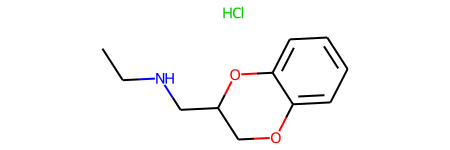

In [29]:
Chem.MolFromSmiles(smiles[60])

We can remove the stereo information as well as the "extra" molecules with string manipulations.

`string.replace("@", "")`

searches the `string` for the character `@` and if it finds one, they are replaced by `""`, so simply removed.

*As an alternative one can also use:*

```python
Chem.MolToSmiles(Chem.MolFromSmiles("N[C@@H](C)C(=O)O"),isomericSmiles=False)
```
The option of using `isomericSmiles = False` was not always available in RDKit.

`string.split(".")`

splits the `string` at each `"."`. The function outputs the individual substrings as a list.


In [30]:
"Choco.l@te".replace("@", "").split(".")

['Choco', 'lte']

In [31]:
sub_molecules = []
for smile in smiles:
    smile = smile.replace("@", "")
    smile = smile.replace("\\", "")
    sub_molecules.append(smile.split("."))

In the next step, we just have to go through the molecule lists. If a smiles consists of several molecules, we simply select the largest molecule as the correct one.

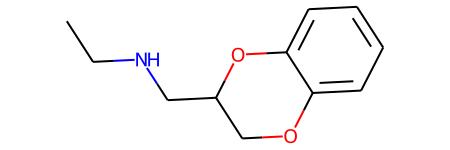

In [32]:
filtered_smiles =[]
for mol_list in sub_molecules:
    filtered_smiles.append(mol_list[np.argmax([len(x) for x in mol_list])])
    
Chem.MolFromSmiles(filtered_smiles[60])

The molecule now no longer has the additional `HCl`.

The smiles are now "clean" and we can start preparing them for the RNN. So create a dictionary and replace the smiles with tokens. For this we again use the `creat_dict` function to create a dictionery for our data. But this time we also use the parameter `add_tokens = True`:

In [34]:
np.random.seed(1234)
dictionary = create_dict(filtered_smiles, add_tokens =True)
dictionary

{'<sos>': 0,
 '<eos>': 1,
 '<pad>': 2,
 '#': 3,
 '(': 4,
 ')': 5,
 '-': 6,
 '/': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '=': 12,
 'C': 13,
 'Cl': 14,
 'F': 15,
 'H': 16,
 'N': 17,
 'O': 18,
 'S': 19,
 '[': 20,
 ']': 21,
 'c': 22,
 'n': 23,
 'o': 24,
 's': 25}

Three new tokens were added to the dictionary, that did not appear in the smiles.

- You already know `<pad>`. It is used to bring all smiles to the same length.

- `<sos>` is a token that announces the start of a smiles. "start of sentence". This token is set **before** each smiles.

- `<eos>` indicates the end of the smiles. After the actual smiles is finished, the `<eos>` token follows, and then the padding token are added (if needed).

So all our smiles should look like this:

```python
"<sos>OCc1ccc2occc2c1<eos><pad><pad>"
```


Why is this necessary? Why are these special tokens needed?

It's due to how a decoder works in an RNN. 

Here again is a reminder, this is what our model looks like:

<img src="Img/rnn/auto_1.png" width ="400px">

We wrote the encoder last week, now we just need to focus on the decoder.
The basic idea of a decoder RNN is that the SMILES are generated one token at a time.

Example:

The decoder receives the latent vector from the encoder:
Based on the latent vector it generates a `C`. Now the decoder can generate another `C` using the latent vector and the information on the already generated `C`. Our current smiles is now `CC`. This step is repeated again, with the knowledge of the latent vector and the already two generated tokens `CC`.
Now the decoder can generate a `=`: `CC=` etc...
Theoretically, this could go on indefinitely. To prevent this the `<eos>` token is ontroduced. This token allows the network to terminate the smiles generation when it "thinks" it is complete.

In the following, it becomes a bit more theoretical:
To understand it in more detail, let's briefly review how an RNN works.

An RNN always has two inputs. One is the regular input, i.e. the current token (smile symbol) for which a prediction has to be made.
In addition, a hidden state is taken from the previous step. The output of the RNN for the previous token.

Through the encoder, we already get the latent vector that will be our initial hidden state for the decoder. 

<img src="Img/rnn/auto_3.png" width ="400px">

But what is our initial input?

<img src="Img/rnn/auto_4.png" width ="400px">

The problem is, if we use the actual first token of the original smile as the first token for the decoder, it's relatively easy to predict it correctly. Therefore, we the token `<sos>` as the first input for the decoder. This token does not contain any information about the input miles. Hence the first tokenfirst token is predicted based only on the hidden state/latent vector. It is also important to note that the output of the RNN (the new hidden state) first passes through a linear layer, which then predicts the correct token.

<img src="Img\rnn\auto_6.png" width ="400px">

In the next step, the new hidden state replaces the latent vector as the input for the next step. Also, instead of using a token of the original smile as input, the token predicted in the previous step by the decoder is used. 
So, if the decoder makes a mistake at the beginning, it continues to decode with that mistake in the generated Smiles.
<img src="Img\rnn\auto_7.png" width ="400px">

This is repeated until the length of the longest smile in our dataset is reached. Of course, most smiles are not that long, so the network e can use the `<eos>` token. This allows the smiles to be terminated before the maximum length is reached. 
<img src="Img/rnn/auto_8.png" width ="400px">

If we use ` (..., add_tokens=True)` in the `tokenize` function, `<sos>` and `<eos>` will be automatically added to each smile. The `0` represents in the `dictionary` the `<sos>` token and the `1` the `<eos>` token.

In [35]:
tokenized_smiles = tokenize(filtered_smiles,dictionary, add_tokens =True)
tokenized_smiles[7]

[0,
 13,
 13,
 8,
 12,
 13,
 13,
 4,
 12,
 18,
 5,
 13,
 9,
 13,
 13,
 8,
 13,
 9,
 4,
 13,
 5,
 13,
 1]

The smiles have still all different lengths. We first calculate the number of tokens in each smile.

In [36]:
token_lengths = np.array([len(x) for x in tokenized_smiles])
max_length=max(token_lengths)
max_length

42

We can also display the number of tokens with a histogram. The problem is, the more tokens a smiles has, the more difficult it is for the decoder to recover the complete smile.

(array([  5.,   8.,   6.,  57.,  48., 130.,  67., 180., 106., 238., 120.,
        219., 101., 115.,  43.,  81.,  41.,  63.,  16.,  17.,   3.,   5.,
          4.,   1.,   1.]),
 array([ 4.  ,  5.52,  7.04,  8.56, 10.08, 11.6 , 13.12, 14.64, 16.16,
        17.68, 19.2 , 20.72, 22.24, 23.76, 25.28, 26.8 , 28.32, 29.84,
        31.36, 32.88, 34.4 , 35.92, 37.44, 38.96, 40.48, 42.  ]),
 <BarContainer object of 25 artists>)

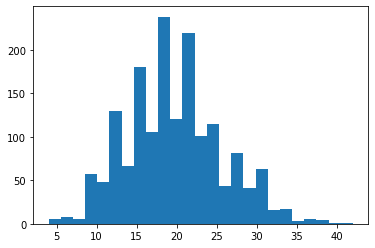

In [37]:
plt.hist(token_lengths, bins=25)

To reduce the impact of smiles length, we could throw out all molecules from the dataset that consist of more than 26 tokens.

In [38]:
np.sum(token_lengths>26)

232

That are exactly 232 molecules. That's not ideal, of course, but it will help us train the network. Especially with so little data, it is difficult to train an autoencoder. Nevertheless, we remove these molecules from the data set.

In [39]:
filtered_smiles=np.array(filtered_smiles)[token_lengths<=26].tolist()
len(filtered_smiles)

1443

With the reduced data, we create a new dictionary and tokenize our data.

In [40]:
dictionary = create_dict(filtered_smiles, add_tokens =True)
tokenized_smiles = tokenize(filtered_smiles,dictionary, add_tokens =True)
tokenized_smiles[:5]

[[0, 12, 12, 12, 12, 12, 12, 12, 4, 11, 17, 5, 17, 12, 12, 12, 1],
 [0,
  12,
  12,
  4,
  12,
  5,
  11,
  12,
  12,
  12,
  12,
  4,
  12,
  5,
  12,
  8,
  12,
  12,
  12,
  4,
  12,
  5,
  12,
  12,
  8,
  1],
 [0, 12, 12, 12, 12, 12, 4, 12, 5, 12, 12, 1],
 [0,
  17,
  11,
  12,
  4,
  19,
  17,
  6,
  20,
  5,
  12,
  11,
  12,
  21,
  8,
  21,
  21,
  21,
  4,
  17,
  5,
  21,
  21,
  8,
  1],
 [0,
  17,
  11,
  12,
  8,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  17,
  8,
  1]]

In [41]:
token_lengths = np.array([len(x) for x in tokenized_smiles])
max_length=max(token_lengths)
max_length

26

All our smiles now consist of a maximum of 26 characters. In a last step we have to bring the smiles that do not consist of 26 tokens to the right length. For this we use the `<pad>` token.

In [42]:
for i, tok_smi in enumerate(tokenized_smiles):
    tokenized_smiles[i] = tok_smi+ [dictionary["<pad>"]]*(max_length - token_lengths[i])

In the last step we convert the lists of tokens into a `tensor`.

In [43]:
tokenized_smiles=torch.tensor(tokenized_smiles, dtype=torch.long)
tokenized_smiles[:5]

tensor([[ 0, 12, 12, 12, 12, 12, 12, 12,  4, 11, 17,  5, 17, 12, 12, 12,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 12, 12,  4, 12,  5, 11, 12, 12, 12, 12,  4, 12,  5, 12,  8, 12, 12,
         12,  4, 12,  5, 12, 12,  8,  1],
        [ 0, 12, 12, 12, 12, 12,  4, 12,  5, 12, 12,  1,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 17, 11, 12,  4, 19, 17,  6, 20,  5, 12, 11, 12, 21,  8, 21, 21, 21,
          4, 17,  5, 21, 21,  8,  1,  2],
        [ 0, 17, 11, 12,  8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 17,  8,  1,  2,  2,  2,  2]])

## Model

Today we will not use `nn.Sequential` to build our model. For simple architectures `nn.Sequential` is a good choice. However, it is not very flexible. 
Therefore, most networks will be written "by hand" in PyTorch.

There are two processes that a network in PyTorch must always perform:

1. initialize the necessary weights 
2. pass the input through the network

The initialization at `nn.Sequential()` is done automatically when the model is created.

In [44]:
model = nn.Sequential(nn.Linear(10,20), nn.ReLU(), nn.Dropout(0.2), nn.Linear(20,1))
model 

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=1, bias=True)
)

In [45]:
list(model.parameters())[1]

Parameter containing:
tensor([ 0.2677,  0.2556, -0.0610, -0.2054, -0.0865,  0.1257, -0.1274,  0.0060,
        -0.2657,  0.1836,  0.2389, -0.1174, -0.0897, -0.0210, -0.0354, -0.0276,
        -0.1335,  0.0564,  0.2465, -0.0102], requires_grad=True)

This is how we have defined our networks so far. Each layer is automatically created and the Weights randomly initialized.

However, we can also define our own networks.
To do this, we need to create a PyTorch class. Classes in Python are similar to functions. Except that classes can also contain properties and their own functions. We will not go into the exact functionalities of classes here.

The only important thing is that we can also create classes that behave like PyTorch classes.
To do this, we first write the following code:

```python
class simple_nn(nn.modules):
```
With this, we specify that the class `simple_nn` is a class that belongs to `nn.Module`. So like other layers or models in PyTorch, it should belong to `nn` or at least function similarly.

Next comes the initialization:  

```python
class simple_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
```

`def __init__(self,input_dim, hid_dim, out_dim, dropout):` is a function that is called when the net is initialized. So for example `model = simple_nn`. Will automatically execute what is written in the `__init__` function. It is important to specify a `self` as input, in addition to the dimensions, that determine the size of the network.

`self` "contains" all the information that are stored for this class. Information stored in `self` can also be used beyond the function in which they were intially placed there. This should become clearer in a few minutes.

`super().__init__()` is part of the code that is important for PyTorch classes. This part must not be missing in the initialization.

Next, we can "store" our linear layers and dropout in `self`:

```python
class simple_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
```

`self.ln1 = nn.Linear(input_dim, hid_dim)` allows us to select the first linear layer with `self.ln1` in other function of the Pytorch class.

In [46]:
class simple_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

In [47]:
model_2 = simple_nn(input_dim=10, hid_dim= 20, out_dim=1, dropout=0.2)
model_2

simple_nn(
  (ln1): Linear(in_features=10, out_features=20, bias=True)
  (ln2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

We can see that the network consists of the correct layers, but in the wrong order. Also the ReLU function is missing. This is not a big deal so far, because the function `__init__` is only supposed to initialize the model, i.e. only create the layers and their weights. ReLU has no weights and therefore does not need to be "initialized".

Here is the proof that the network `model_2` now has random weights.

In [48]:
list(model_2.parameters())[1]

Parameter containing:
tensor([-0.1537,  0.1427, -0.0019,  0.0311, -0.2681, -0.1257, -0.1831,  0.1772,
         0.0488, -0.0386,  0.0610, -0.2738,  0.0278,  0.0345,  0.1009, -0.1042,
        -0.2200,  0.0309,  0.2338,  0.0092], requires_grad=True)

We can try if the model can generate an output from an input (`fake_input` consists of random numbers).

In [49]:
fake_input = (torch.rand(10))

model(fake_input)

tensor([0.0854], grad_fn=<AddBackward0>)

No problem for the `nn.Sequential` model.

In [50]:
fake_input = (torch.rand(10))

model_2(fake_input)

NotImplementedError: 

This error 

```python
raise NotImplementedError
```
is printed. This indicates that we have not implemented this part of the model, i.e. we have not defined it in the class yet.

So far `simple_nn` can only initialize the weights. But it does not yet know how to pass the inputs through the neural network. In `nn.Sequential` this is done automatically. The input is simply passed through the layers one after the other. The sequence is determined by the order of these layers at initialization. 

To make this work for our own class, we need another function called 

```python
def forward(self, x):
```

`forward` is, as the name implies, responsible for forward pass. It determines in what order input `x` is passed through the previously defined layers.
It is also important to note that `self` is another input besides `x`. `self` contains all the information we have already defined in `__ìnit__`.

```python
class simple_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        x = self.ln1(x)
        x = self.dropout(x)
        x = nn.functional.relu(x)
        output = self.ln2(x)
        return output
```


Here we specify step by step what should happen to the original input. In the first step `x` is passed through the first linear layer. This was stored in `self.ln1`. Only for the activation function we don't need `self`, because it was not initialized.

---
**It is also important that we now cannot use**`nn.ReLU` **any more, but we must use** `.nn.functional.relu()`**.** 

---

In [51]:
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        x = self.ln1(x)
        x = self.dropout(x)
        x = nn.functional.relu(x)
        output = self.ln2(x)
        return output
    
model_2 = einfaches_nn(input_dim=10,hid_dim= 20, out_dim=1, dropout=0.2)
model_2    

einfaches_nn(
  (ln1): Linear(in_features=10, out_features=20, bias=True)
  (ln2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Nothing has changed in the initialization, but we can now pass inputs through the network.

In [52]:
model_2(fake_input)

tensor([-0.0135], grad_fn=<AddBackward0>)

Now we can design more complex networks that don't have just one input.

## Encoder

Now back to our autoencoder.
First we define the encoder.
We have an `nn.Embedding` layer and an `nn.GRU` layer. The encoder is built exactly like the RNN in the last notebook, except that here we explicitly write the network ourselves.

Take a look at the `forward` function. As input it takes a `input_seq`, which is a sequence of tokens. The output is the last `hidden` state of the network. This describes the complete smiles and is also our latent vector.

In [53]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim 
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_seq):
        embedded = self.dropout(self.embedding(input_seq))
        outputs, hidden = self.rnn(embedded) 
        return hidden
    

## Decoder 

The decoder is already a bit more complex.  If you don't understand the complete code, that's fine. As long as you can follow the general concept.
Again we have an `Embedding` Layer and a `GRU` Layer, additionally there is a Linear Layer. This layer determines which token to generate based on the hidden state.

In the `forward` pass there are two inputs. Once the `input`, this is the last token, which was predicted. At the beginning this is the`<sos>` token. `hidden` is the hidden state of the `GRU` from the previous step.
`forward` outputs both the `prediction`, the predicted token, and `hidden`, the new hidden state.

In [54]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output[0])
        
        return prediction, hidden

Finally we merge both components in an `autoencoder`. As input this model takes a decoder and an encoder.  The autoencoder also has its own `forward` pass. First the input is passed through the encoder. The encoder provides us with the hidden state `hidden`. This hidden state is then used once at the beginning of the `for-loop` for the decoder. Also, we take the first column of `output_seq` as the first input to the decoder. This column consists of the `<sos>` tokens.

Additionally, we introduce  teacher forcing. Teacher forcing is used during training to make it easier for the decoder to recover the full smiles. If the decoder suggests an incorrect token at the beginning of a smile, the decoder must continue computing with that incorrect token as input. This can be a problem especially at the beginning of the training, because many mistakes are made here. By using teacher forcing the predicted token is replaced by the correct token. Thus the decoder can continue to calculate with the correct token. Teacher forcing is  switched off during the evaluation. 

In [55]:
  
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

        
    def forward(self, input_seq, output_seq, teacher_forcing_ratio = 0.5):
        
        # save parameters
        batch_size = output_seq.shape[1]
        trg_len = output_seq.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        
        
        # Actual Forward Pass
        
        # The encoder calculates the hidden state/latent vector
        hidden = self.encoder(input_seq)
        
        # As initial input for the decoder we select the <sos> tokens
        input = output_seq[0,:]
        
        # The for-loop is used to generate the tokens one after the other.
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1) 

            input = output_seq[t] if teacher_force else top1

        return outputs

As already said, it's okay if you don't understand every detail in this case.

To create the autoencoder we first need to define our model.

In [71]:
torch.manual_seed(1234)
enc = Encoder(len(dictionary), 128, 256, 0.2)
dec = Decoder(len(dictionary),128,256,0.2)
model = Autoencoder(enc, dec)
model

Autoencoder(
  (encoder): Encoder(
    (embedding): Embedding(25, 128)
    (rnn): GRU(128, 256)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(25, 128)
    (rnn): GRU(128, 256)
    (fc_out): Linear(in_features=256, out_features=25, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

You can clearly see the different components of the autoencoder.
We also create a `DataLoader`. For $x$ and $y$ it uses same sequence, because we want to train an autoencoder which reconstructs $x$. We also store a sample batch `ex_in` and `ex_out`.

Since we have so little data, we don\`t use a test dataset.

In [72]:
train_dataset = TensorDataset(tokenized_smiles, tokenized_smiles)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
ex_in= ex_out = tokenized_smiles[:16,:]

We define our optimizer and our loss function. Here we can also specify that the index `2` should be ignored when calculating the loss. This is the index for the `<pad>` token. 

In [73]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = 2)

The last step is the training loop. This is a regular `for-loop`, but we use the transpose of the `input_seq` and the `output_seq`. This is because the functions of the netowrks merge more easily this way. 

In the training loop itself, the quality of the generated smiles is evaluated every five epochs. It is evaluated based on how many generated smiles are valid and how many of them are actually identical to the input.

This is done by the function `evaluate()`, which was pre-written for you.

In [74]:
random.seed(1234)
for epoch in range(100):
    epoch_loss = 0

    model.train()
    for input_seq, output_seq in train_loader:
        optimizer.zero_grad()        
        
        input_seq = input_seq.t()
        output_seq = output_seq.t()


        output = model(input_seq, output_seq, 0.2)
        
        
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        output_seq =  output_seq[1:].reshape(-1)
        
        loss = criterion(output,  output_seq)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
    if (epoch%5==0):
        valid, correct=evaluate(model, train_loader, dictionary)
        print(f"Epoch {epoch}: Loss: {epoch_loss /len(train_loader)} % Valid: {valid.round(2)} % Correct: {correct.round(2)} ")
    else:
        print(f"Epoch {epoch}: Loss: {epoch_loss /len(train_loader)}")
    

Epoch 0: Loss: 1.8249785284419635 % Valid: 0.69 % Correct: 0.0 


KeyboardInterrupt: 

Now we can see how good our model really is. For the evaluation teacher forcing is turned off.

In [ ]:
evaluate(model,train_loader, dictionary)

Our autoencoder actually generates valid smiles. Many of the generated smiles are actually identical to the input smiles.

Autoencoders are difficult to train, especially for languages or Smiles. The grammar of Smiles has to be learned first. This actually requires much more data. Moreover, we use a very simple model. Nevertheless, we can take a closer look at the network.

For example, we can look at the predictions for our `ex_in` batch.

In [ ]:
model.eval()
pred = model(ex_in.t(), ex_out.t(), 0)
pred_tokens =pred.argmax(2).t().detach().numpy()

pred_tokens[:2]

For comparison, the original smiles:

In [ ]:
ex_out[:2]

The function `token_to_smiles` converts the tokens back to smiles:
This is what the predicted smiles look like:

In [ ]:
pred_smiles = tokens_to_smiles(pred_tokens,dictionary )
true_smiles = tokens_to_smiles(ex_out.detach().numpy(), dictionary)
pd.DataFrame({"true":true_smiles, "pred": pred_smiles })

In fact, most smiles are identical to the original. But there are also deviating smiles. The smiles with index 8 is not identical and is not even a valid Smiles.

# Generate new molecules

We have a decoder that can generate valid molecules from our hidden states/latent vectors. 
So far, we have obtained the latent vectors by passing known smiles through the encoder. But what's stopping us from generating random latent vectors and seeing what the decoder generates from them? Our hidden states/latent vectors have this size:

In [ ]:
latent_vectors =  model.encoder(ex_in.t()).detach().numpy()
latent_vectors.shape

We can simply create an alternative latent `tensor`. We fill this one with random numbers.

In [ ]:
torch.manual_seed(5489786)
hidden = torch.randn(1,16,256)

We use this instead of the original `tensor` as input for the decoder.
The decoder should now try to generate new smiles from this random data. Since the hidden state was chosen randomly, the generated molecules shouldnot be part of our original data set. This is one example of de novo design.

In [ ]:
outputs = torch.zeros(26, 16, len(dictionary))
input_ = ex_out.t()[0,:] #<- ["<sos>"] Tokens
for t in range(1, 26):
    output, hidden = model.decoder(input_, hidden)
    outputs[t] = output
    input_ = output.argmax(1) 



In [ ]:
pred_tokens = outputs.argmax(2).t().detach().numpy()
new_smiles = tokens_to_smiles(pred_tokens, dictionary)
new_smiles

In fact, none of these molecules are included in our data set. This is mainly because most of them are not valid molecules. 

The problem is mainly that the latent space, i.e. the total space that can be described by our latent vectors, is too large. It will be very difficult to find random numbers that give a valid molecule.

To really generate molecules effectively using autoencoders, we need much more data. That way the grammar of smiles can be learned better. Also, so-called variational autoencoders (VAEs) are most commonly used. These "force" the latent space into a predefined space. If one then chooses random numbers within the same defined space, the probability that the generated smiles is a valid molecule is higher.

# Übungsaufgabe

Today\`s exercise is not about autoencoders. The task is to rewrite an `nn.Sequential` model into a working PyTorch class.

The model looks like this:

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit import RDLogger  
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
RDLogger.DisableLog('rdApp.*')      
%run ../utils/utils.py

In [ ]:
model_1 =nn.Sequential(nn.Linear(20,100),
              nn.BatchNorm1d(100),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(100,100),
              nn.BatchNorm1d(100),
              nn.ReLU(),
              nn.Linear(100,10))
model_1

Rewrite the model. Note that `nn.ReLU` does not work in `forward`. Please use `nn.functional.relu()`. It is also important to know that `__init__` can have as many input parameters as you want, for example you can write `__init__` like this:
`__init__(self, input_dim, hid1_dim, hid2_dim, ________)` to initialize multiple hidden layers.

In [ ]:
class simple_nn(________):
    def __init__(self, ___________________________________________):
        super().__init__()
        
    def forward()    

In [ ]:
model_2 = simple_nn(______________________________)

Test if your model generates an output.

In [ ]:
torch.manual_seed(213)
test_data = torch.randn(100,20)

model_2(test_data)

In [ ]:
list(model.parameters())[10]